In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cd_diagram import draw_cd_diagram

from IPython.display import display

%matplotlib inline

#sns.set()

# Helper functions

In [2]:
def get_best_row(group):
    idx_min_rmsse = group.rmsse.idxmin()
    return group.loc[idx_min_rmsse].drop('id_piezo')

In [3]:
def plot_best_models(result_df):
    best_models = result_df.reset_index(drop=True).groupby('id_piezo').apply(get_best_row)
    models_and_stations = best_models.join(sources)
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([-5, 10, 42, 52])

    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    sns.scatterplot(data=models_and_stations, x='x', y='y', hue='model', ax=ax) 

    ax.set_title('France');

    plt.tight_layout()
    plt.show()
#plt.savefig('Images/plot_clusters.png')

In [4]:
def plot_stats(result_df, figsize=(8, 5), fname=None):
    plt.figure(figsize=figsize)
    ax = sns.boxplot(data=result_df, y='rmsse', x='model')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yscale('log')
    
    plt.tight_layout()
    
    if fname is not None:
        plt.savefig(fname)
        
    plt.show()
    
    agg_metrics = result_df.groupby('model')[['rmsse']].agg(['mean', 'std']).T
    display(agg_metrics)

In [5]:
def plot_forecast(forecast_df): 

    nrows = 6
    ncols = 3

    plt.figure(figsize=(20, 20))

    for i, (index, row) in enumerate(forecast_df[['BSS_ID', 'NOM_COMMUNE']].iterrows()):
        df = forecast_def[forecast_def.index==index]
        df = df.set_index('DATE')

        ax = plt.subplot(nrows, ncols, i+1)
        df.plot(ax=ax, title=f'Piézomètre {row.BSS_ID} ({row.NOM_COMMUNE})', xlabel='')
        
        if i == 17:
            break

    plt.tight_layout()
    #plt.savefig('Images/forecasts.png')
    plt.show()

In [6]:
def show_performance(result_df, show_map=False, barplot_fname=None, cd_fname=None):
    res = result_df.copy()
    if res.shape[0] > 0:
        plot_stats(res, fname=barplot_fname)

        if show_map:
            plot_best_models(res)
            
        try :
            res.rmsse = -res.rmsse
            draw_cd_diagram(res.rename(columns={'id_piezo': 'dataset_name', 'model': 'classifier_name', 'rmsse': 'accuracy'}), fname=cd_fname)
            plt.show()
        except Exception as e:
            print(e)
            
    else:
        print('No result for these covariates\n\n\n')

In [7]:
def rename_model(row):
    name = row.model
    if row.use_exo_rain:
        name += '+rain'
    if row.use_exo_eto:
        name += '+eto'
    row.model = name
    return row

In [12]:
result_folder = './'

# Load stations

In [8]:
sources = pd.read_csv('../data_collection/stations.csv', delimiter=',', index_col=0)
sources.head()

,x,y,geometry,dpt,prof,alt,masse_eau,codes_bdlisa,CodeEH,InclusEH,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH
bss,,,,,,,,,,,,,,,
06216X0228/P30-10,3.401730,46.272865,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",03,8.0,237.20,"[""Alluvions de l'Allier aval""]",932AR01,932AR01,932AR,2,5.0,1,1.0,1.0
05373X0546/5410,-0.879629,47.059019,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",49,23.4,106.00,['Bassin versant de la Sèvre Nantaise'],181AE01,181AE01,181AE,2,6.0,2,3.0,1.0
01193X0168/FEA10,-0.488171,49.295510,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",14,30.0,13.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10396X0083/SA10,3.022001,43.209046,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",11,19.3,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07372X0048/F10,1.538653,45.529764,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",19,138.0,396.00,NaN,372AG03,372AG03,372AG,2,6.0,2,3.0,1.0


In [9]:
common_piezo = pd.read_csv('piezos_communs.csv').squeeze()
print(common_piezo.shape)
common_piezo.head()

(1055,)


0       00065X0148/P
1    00068X0010/F295
2     00127X0873/PZ1
3     00134X0127/PZ1
4      00148D0177/F2
Name: id_piezo, dtype: object

In [10]:
missing_source = set(common_piezo).difference(sources.index)
print(missing_source)

{'07223C0113/S', '01258X0020/S1', '06505X0080/FORC'}


# Legacy results

In [12]:
files = [result_folder + 'oldTG_local_part1.csv', 
          result_folder + 'oldTG_local_part2.csv',
          result_folder + 'oldTG_local_part3.csv',
          result_folder + 'oldTG_local_part4.csv',
          result_folder + 'oldTG_local_cmpl.csv',
          result_folder + 'oldTG_local_xgb.csv']
legacy_result = pd.concat([pd.read_csv(file, delimiter='\t') for file in files])
legacy_result['rmse'] = np.sqrt(legacy_result.mse)
legacy_result = legacy_result.rename(columns={'id_method_ML': 'model'})
legacy_result = legacy_result[~legacy_result.approx_exo]
legacy_result = legacy_result[legacy_result.id_piezo.isin(common_piezo)]
legacy_result.model = legacy_result.model.apply(lambda m: m.upper())
legacy_result = legacy_result.apply(rename_model, axis=1)

legacy_result.head()

,id_piezo,model,type,r,use_exo_rain,use_exo_eto,use_exo_bdlisa,approx_exo,rmsse,mse,rmse
0,00065X0148/P,LM,Local,100.0,False,False,False,False,0.678561,0.010110,0.100549
2,00065X0148/P,LM+rain,Local,100.0,True,False,False,False,3.557765,0.277926,0.527187
4,00065X0148/P,LM+rain+eto,Local,100.0,True,True,False,False,1.676050,0.061680,0.248356
6,00065X0148/P,SVR,Local,100.0,False,False,False,False,2.311324,0.117299,0.342490
8,00065X0148/P,SVR+rain,Local,100.0,True,False,False,False,1.311381,0.037760,0.194319


In [12]:
legacy_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15825 entries, 0 to 6823
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_piezo        15825 non-null  object 
 1   model           15825 non-null  object 
 2   type            15825 non-null  object 
 3   r               12660 non-null  float64
 4   use_exo_rain    15825 non-null  bool   
 5   use_exo_eto     15825 non-null  bool   
 6   use_exo_bdlisa  15825 non-null  bool   
 7   approx_exo      15825 non-null  bool   
 8   rmsse           14770 non-null  float64
 9   mse             14770 non-null  float64
 10  rmse            14770 non-null  float64
dtypes: bool(4), float64(4), object(3)
memory usage: 1.0+ MB


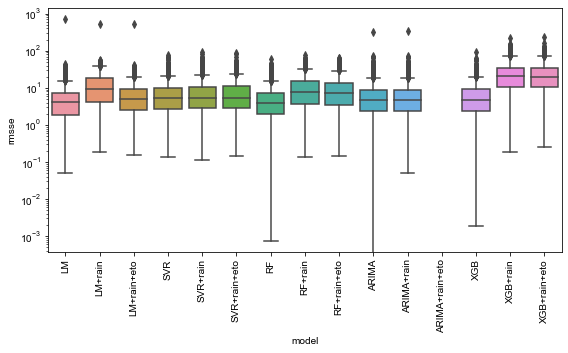

model           ARIMA  ARIMA+rain  ARIMA+rain+eto         LM    LM+rain  \
rmsse mean   7.412144    7.451601             NaN   6.283703  13.184160   
      std   12.526221   12.942200             NaN  22.627880  19.183024   

model       LM+rain+eto        RF    RF+rain  RF+rain+eto       SVR  SVR+rain  \
rmsse mean     7.567002  5.960052  11.112012    10.182631  8.057855  8.703804   
      std     17.097965  6.512028  10.759838     9.790819  8.759922  9.801658   

model       SVR+rain+eto       XGB   XGB+rain  XGB+rain+eto  
rmsse mean      8.647361  7.348983  26.428319     25.737982  
      std       9.516118  8.068334  23.083427     22.523360

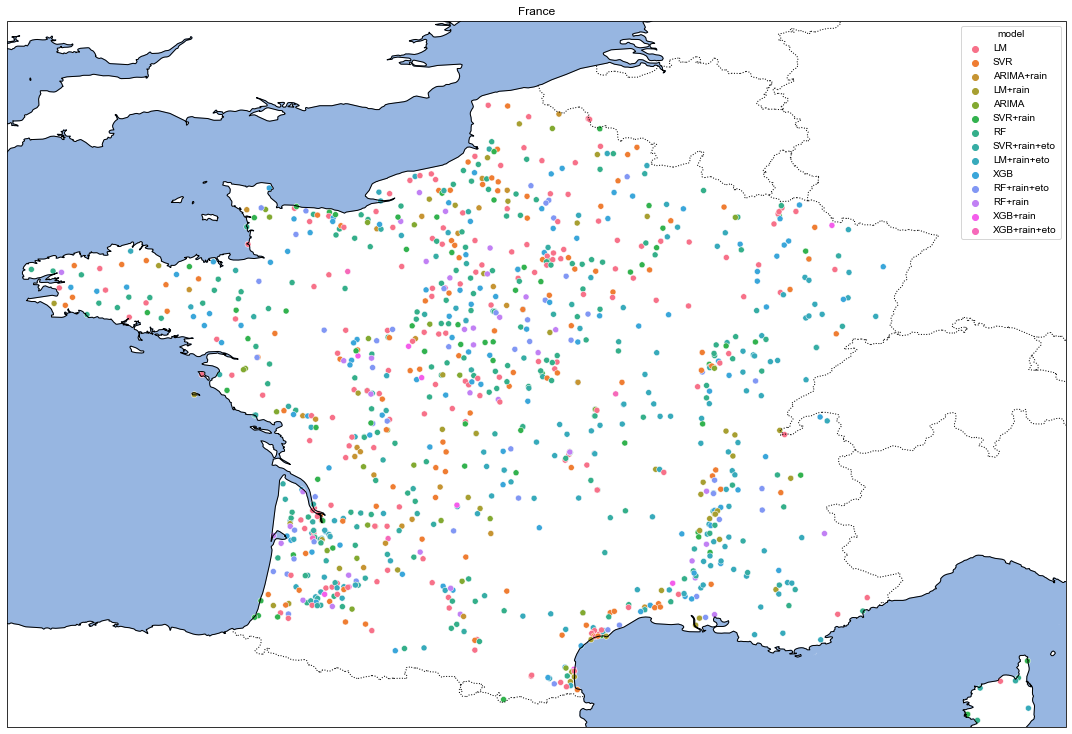

{0: 'XGB+rain', 1: 'XGB+rain+eto', 2: 'LM+rain', 3: 'RF+rain', 4: 'RF+rain+eto', 5: 'SVR', 6: 'SVR+rain', 7: 'SVR+rain+eto', 8: 'ARIMA', 9: 'ARIMA+rain', 10: 'XGB', 11: 'LM+rain+eto', 12: 'RF', 13: 'LM', 14: 'ARIMA+rain+eto'}
[5, 6, 7]
[8, 9, 10, 11]
[12, 13]


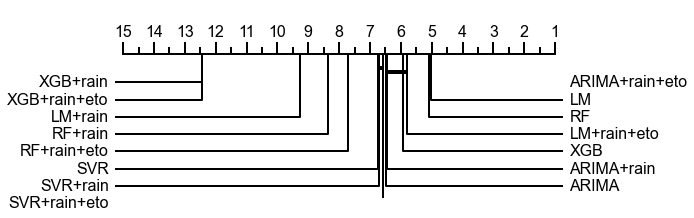

In [13]:
show_performance(legacy_result, show_map=True, barplot_fname='Images/boxplot-legacy.jpg', cd_fname='Images/cd-legacy.jpg')

# Deepar results

In [14]:
deepar_local_result = pd.read_csv(result_folder + 'local_DeepAR.csv', index_col=0)
deepar_local_result = deepar_local_result.rename(columns={'item_id': 'id_piezo', 'use_exo_evo': 'use_exo_eto'})
deepar_local_result = deepar_local_result[deepar_local_result.id_piezo.isin(common_piezo)]

if 'use_exo_bdlisa' not in deepar_local_result.columns:
    deepar_local_result['use_exo_bdlisa'] = False
    
deepar_local_result['type'] = 'Local'
deepar_local_result['model'] = 'DeepAR-L'

deepar_global_result = pd.read_csv(result_folder + 'global_DeepAR.csv', index_col=0)
deepar_global_result = deepar_global_result.rename(columns={'item_id': 'id_piezo', 'use_exo_evo': 'use_exo_eto'})
deepar_global_result = deepar_global_result[deepar_global_result.id_piezo.isin(common_piezo)]
deepar_global_result.rmsse = deepar_global_result.rmsse.astype(float)
deepar_global_result = deepar_global_result.replace(to_replace='False', value=False)
deepar_global_result.use_exo_rain = deepar_global_result.use_exo_rain.astype(bool)
deepar_global_result.use_exo_eto = deepar_global_result.use_exo_eto.astype(bool)

if 'use_exo_bdlisa' not in deepar_global_result.columns:
    deepar_global_result['use_exo_bdlisa'] = False
    
deepar_global_result['type'] = 'Global'
deepar_global_result['model'] = 'DeepAR-G'

deepar_result = pd.concat([deepar_local_result, deepar_global_result])
deepar_result = deepar_result.apply(rename_model, axis=1)
deepar_result.head()

,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id_piezo,MSE,abs_error,...,model,learningtime,use_exo_rain,use_exo_eto,rmse,rmsse,use_exo_bdlisa,type,use_exo_lisa,TN
4,4.0,4.0,4.0,4.0,4.0,4.0,0.0,00065X0148/P,0.308370,44.914196,...,DeepAR-L+rain+eto,278.069091,True,True,0.555310,3.577621,False,Local,NaN,NaN
5,5.0,5.0,5.0,5.0,5.0,5.0,0.0,00065X0148/P,0.214006,36.915985,...,DeepAR-L+rain,279.152479,True,False,0.462608,2.980377,False,Local,NaN,NaN
6,6.0,6.0,6.0,6.0,6.0,6.0,0.0,00065X0148/P,0.283600,44.821762,...,DeepAR-L+eto,293.467366,False,True,0.532541,3.430925,False,Local,NaN,NaN
7,7.0,7.0,7.0,7.0,7.0,7.0,0.0,00065X0148/P,0.520745,61.014584,...,DeepAR-L,300.382821,False,False,0.721627,4.649122,False,Local,NaN,NaN
8,8.0,8.0,8.0,8.0,8.0,8.0,0.0,00068X0010/F295,1.712516,106.250275,...,DeepAR-L+rain+eto,278.234030,True,True,1.308631,8.063753,False,Local,NaN,NaN


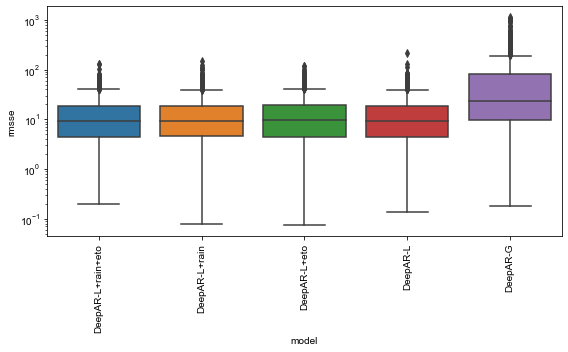

model         DeepAR-G   DeepAR-L  DeepAR-L+eto  DeepAR-L+rain  \
rmsse mean   71.492327  14.686831     14.807247      14.637715   
      std   126.829929  16.599926     15.675847      16.217645   

model       DeepAR-L+rain+eto  
rmsse mean           14.26152  
      std            15.16307

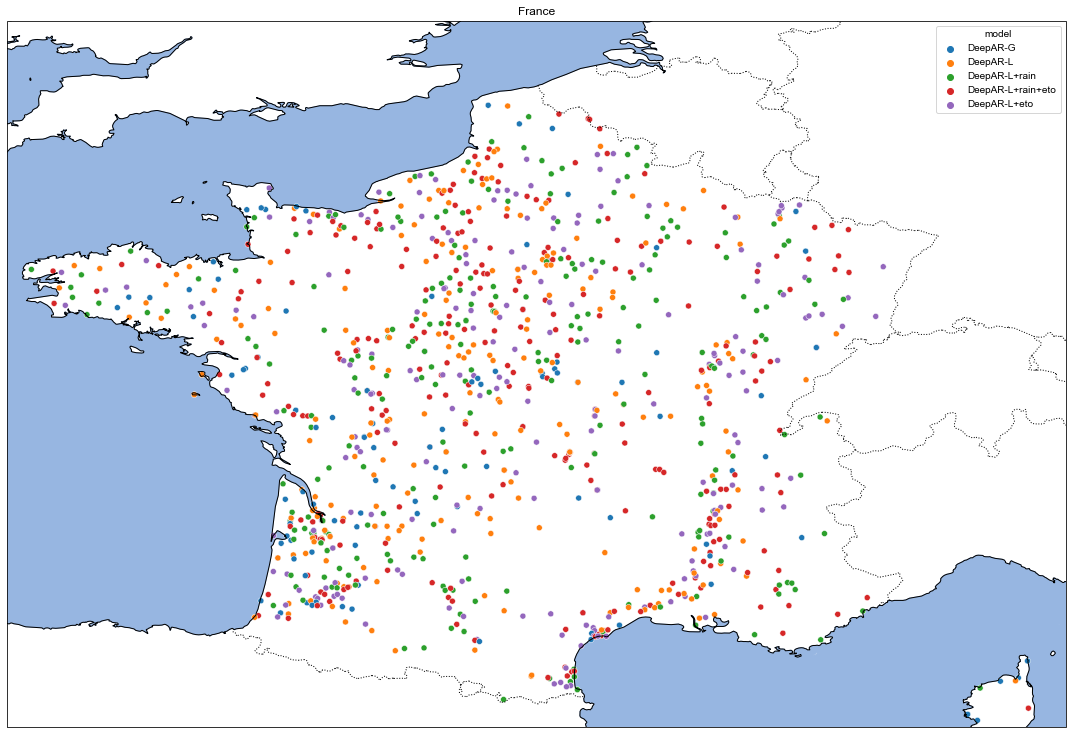

{0: 'DeepAR-G', 1: 'DeepAR-L+eto', 2: 'DeepAR-L+rain+eto', 3: 'DeepAR-L+rain', 4: 'DeepAR-L'}
[1, 2, 3, 4]


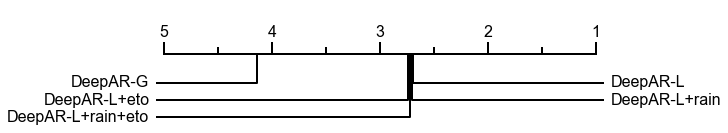

In [16]:
show_performance(deepar_result, show_map=True, barplot_fname='Images/boxplot-deepar.jpg', cd_fname='Images/cd-deepar.jpg')

# Prophet, NeuralProphet and Conv results

In [14]:
neuralprophet_global = pd.read_csv(result_folder+'neuralprophet_global.csv', delimiter=',').rename(columns={'Unnamed: 0': 'bss_code'})
neuralprophet_global.model = 'NeuralProphet-G'
neuralprophet_global['type'] = 'Global'

files = [
          result_folder + 'local_prophet.csv', 
          result_folder + 'local_neuralprophet.csv',
          #result_folder + 'local_Conv.csv',
        ]

deeplearning_result = pd.concat([pd.read_csv(file, delimiter=',') for file in files])
deeplearning_result.model = deeplearning_result.model.replace('neuralprophet', value='NeuralProphet-L')
deeplearning_result['type'] = 'Local'

deeplearning_result = pd.concat([deeplearning_result, neuralprophet_global], axis=0)

deeplearning_result = deeplearning_result.rename(columns={'bss_code': 'id_piezo', 'rmse_test': 'rmse', 'rmsse_test': 'rmsse', 'use_exo_evo': 'use_exo_eto'})
deeplearning_result = deeplearning_result[deeplearning_result.id_piezo.isin(common_piezo)]
deeplearning_result.model = deeplearning_result.model.replace({'prophet': 'Prophet'})


if 'use_exo_bdlisa' not in deeplearning_result.columns:
    deeplearning_result['use_exo_bdlisa'] = False

deeplearning_result = deeplearning_result.apply(rename_model, axis=1)
deeplearning_result.head()

,id_piezo,model,rmse_train,rmse,rmsse_train,rmsse,learningtime,use_exo_rain,use_exo_eto,h1,...,h86,h87,h88,h89,h90,h91,h92,h93,type,use_exo_bdlisa
4,00065X0148/P,Prophet,0.308735,0.282583,2.007717,1.837651,0.702274,False,False,1.082109,...,0.763810,0.781719,0.764617,0.750875,0.745400,0.757558,0.737699,0.750746,Local,False
5,00065X0148/P,Prophet+rain,0.301175,0.258691,1.958556,1.682278,0.643840,True,False,1.131278,...,0.816696,0.836948,0.825391,0.771921,0.652766,0.714907,0.350567,0.811579,Local,False
6,00065X0148/P,Prophet+eto,0.299752,0.248236,1.949303,1.614289,0.794361,False,True,1.091117,...,0.802474,0.857490,0.826903,0.773760,0.613735,0.806678,0.731351,0.748738,Local,False
7,00065X0148/P,Prophet+rain+eto,0.294434,0.243034,1.914715,1.580461,0.616374,True,True,1.127481,...,0.838248,0.889592,0.865493,0.786197,0.557603,0.763794,0.418859,0.796979,Local,False
8,00068X0010/F295,Prophet,0.271972,1.261550,1.678213,7.784430,2.905123,False,False,24.423687,...,21.993809,21.947244,21.886258,21.856302,21.809436,21.748219,21.685697,21.647721,Local,False


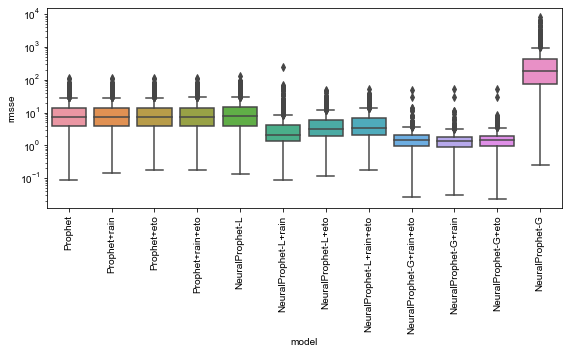

model       NeuralProphet-G  NeuralProphet-G+eto  NeuralProphet-G+rain  \
rmsse mean       390.138255             1.656578              1.532750   
      std        716.540649             2.037317              2.093355   

model       NeuralProphet-G+rain+eto  NeuralProphet-L  NeuralProphet-L+eto  \
rmsse mean                  1.740952        12.441372             4.942578   
      std                   2.150222        14.610189             5.354650   

model       NeuralProphet-L+rain  NeuralProphet-L+rain+eto    Prophet  \
rmsse mean              4.410747                  5.423677  11.689310   
      std               9.970308                  5.590086  12.925451   

model       Prophet+eto  Prophet+rain  Prophet+rain+eto  
rmsse mean    11.676036     11.676413         11.666413  
      std     12.931519     12.944965         12.948659

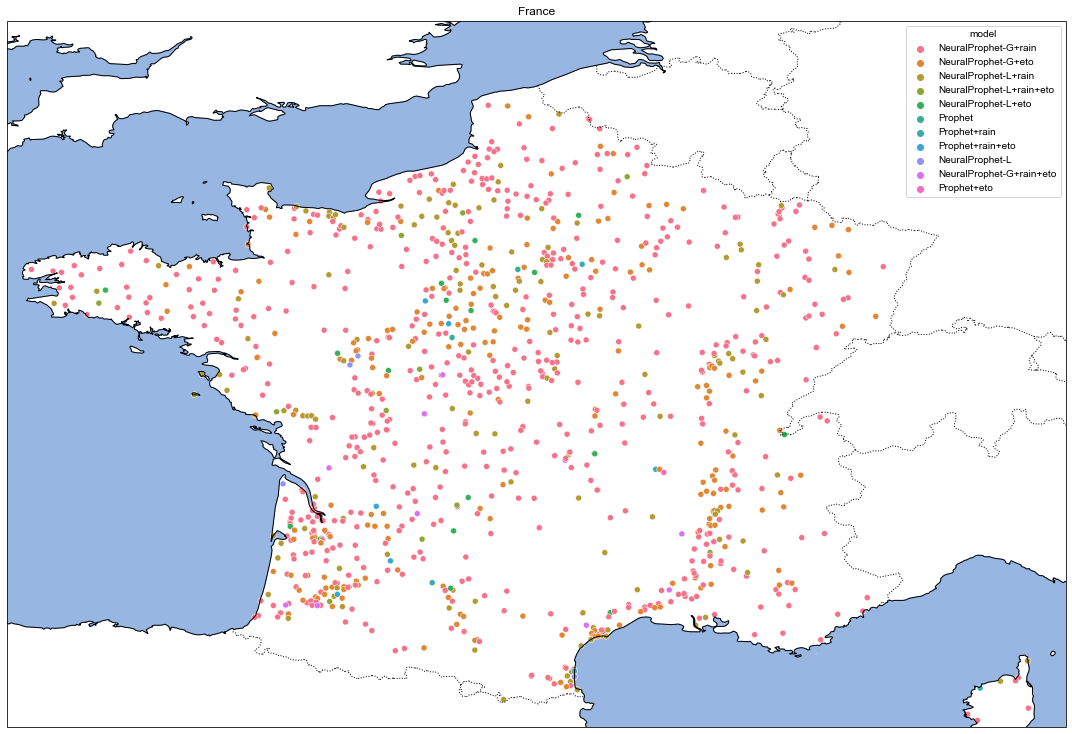

{0: 'NeuralProphet-L', 1: 'Prophet', 2: 'Prophet+eto', 3: 'Prophet+rain', 4: 'Prophet+rain+eto', 5: 'NeuralProphet-L+rain+eto', 6: 'NeuralProphet-L+eto', 7: 'NeuralProphet-L+rain'}
[2, 3]


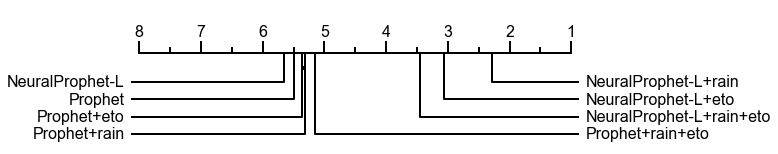

In [51]:
show_performance(deeplearning_result, show_map=True, barplot_fname='Images/boxplot-prophet.jpg', cd_fname='Images/cd-prophet.jpg')

# Merge every results

In [15]:
all_result = pd.concat([legacy_result, deepar_result, deeplearning_result])
all_result = all_result[all_result.use_exo_bdlisa==False]

filter_cols = ['id_piezo', 'model', 'type', 'use_exo_rain', 'use_exo_eto', 'use_exo_bdlisa', 'rmsse', 'rmse']
all_result_filtered = all_result[filter_cols]

all_result_filtered = all_result_filtered.apply(lambda row: rename_model(row), axis=1)

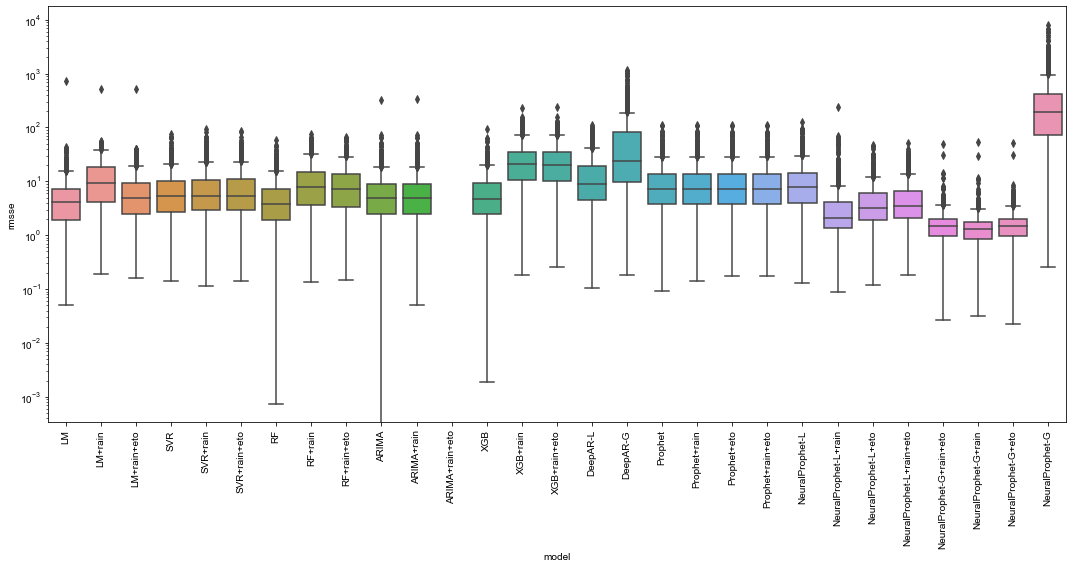

model           ARIMA  ARIMA+rain  ARIMA+rain+eto    DeepAR-G   DeepAR-L  \
rmsse mean   7.412144    7.451601             NaN   71.492327  14.455558   
      std   12.526221   12.942200             NaN  126.829929  15.690428   

model              LM    LM+rain  LM+rain+eto  NeuralProphet-G  \
rmsse mean   6.283703  13.184160     7.567002       390.138255   
      std   22.627880  19.183024    17.097965       716.540649   

model       NeuralProphet-G+eto  ...  Prophet+rain+eto        RF    RF+rain  \
rmsse mean             1.656578  ...         11.666413  5.960052  11.112012   
      std              2.037317  ...         12.948659  6.512028  10.759838   

model       RF+rain+eto       SVR  SVR+rain  SVR+rain+eto       XGB  \
rmsse mean    10.182631  8.057855  8.703804      8.647361  7.348983   
      std      9.790819  8.759922  9.801658      9.516118  8.068334   

model        XGB+rain  XGB+rain+eto  
rmsse mean  26.428319     25.737982  
      std   23.083427     22.523360  

[2 rows x 29 columns]

In [84]:
plot_stats(all_result_filtered, figsize=(15, 8), fname='Images/boxplot-all.jpg')

- On peut voir que l'utilisation des données exogènes dégrade les performances de LM, et ceci en particulier lorsqu'on utilise la pluie. C'est également le cas pour RF, XGB, 
- Les données exogènes dégradent légèrement le modèle SVR et n'ont aucun apport pour les modèles ARIMA, Prophet 
- DeepAR-Global est beaucoup moins bon que DeepAR-Local.
- On observe une amélioration considérable des prévisions de NeuralProphet lorsque les données exogènes sont utilisées, en particulier lorsque seule la pluie est utilisée. Une amélioration est également observée sur le modèle Conv, mais elle est très légère.

On vera par la suite à l'aide d'un diagramme de différence critique si ces améliorations/détériorations sont statistiquement significatives.

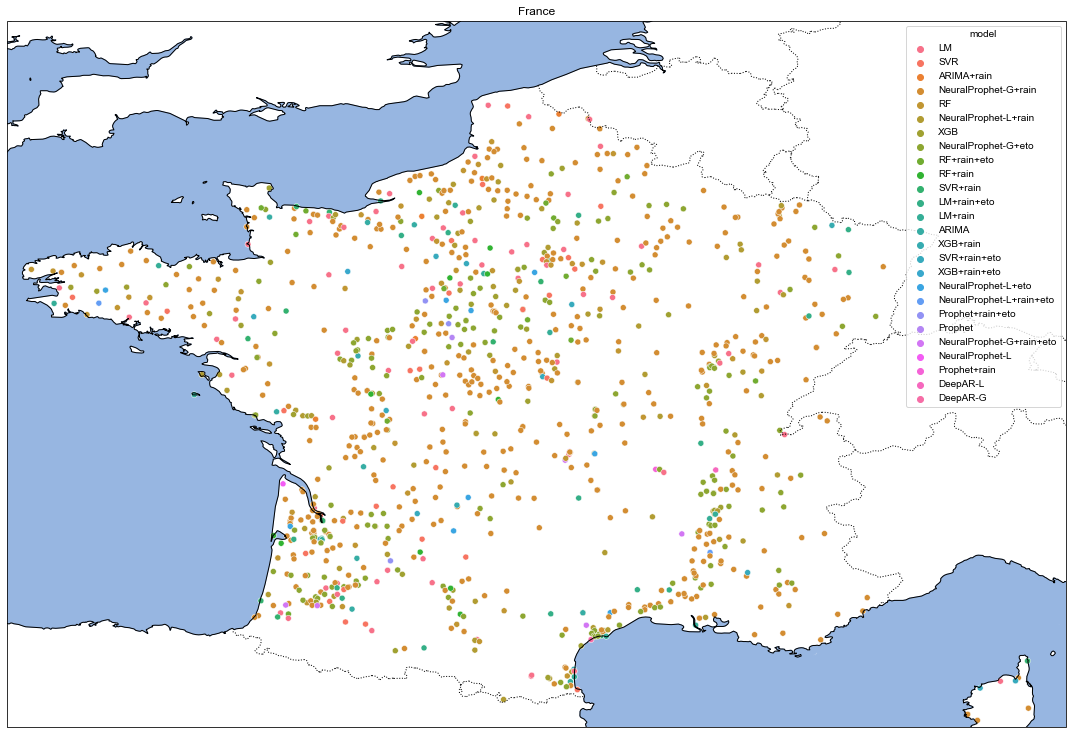

In [85]:
plot_best_models(all_result_filtered)

In [16]:
commons = set(common_piezo.values)
models_with_no_result = []
for m in all_result_filtered.model.unique():
    tmp = all_result_filtered[all_result_filtered.model == m].dropna()
    if tmp.shape[0] > 0:
        commons = commons.intersection(tmp.id_piezo)
    else:
        models_with_no_result.append(m)

print('Number of common piezo: ', len(commons), '\nModels without results:', models_with_no_result)

Number of common piezo:  1026 
Models without results: ['ARIMA+rain+eto+rain+eto']


In [17]:
common_df = all_result_filtered[all_result_filtered.id_piezo.isin(commons)]
common_df = common_df[~common_df.model.isin(models_with_no_result)]
common_df = common_df.rename(columns={'id_piezo': 'dataset_name', 'model': 'classifier_name', 'rmsse': 'accuracy'})

In [89]:
# A dataframe with all performance
pd.pivot(data=common_df, columns='classifier_name', values='accuracy', index='dataset_name').to_csv('all-performance.csv')

{0: 'NeuralProphet-G', 1: 'XGB+rain+eto', 2: 'XGB+rain', 3: 'DeepAR-G', 4: 'LM+rain', 5: 'DeepAR-L', 6: 'NeuralProphet-L', 7: 'RF+rain', 8: 'Prophet', 9: 'Prophet+eto', 10: 'Prophet+rain', 11: 'Prophet+rain+eto', 12: 'RF+rain+eto', 13: 'SVR+rain', 14: 'SVR+rain+eto', 15: 'SVR', 16: 'ARIMA', 17: 'ARIMA+rain', 18: 'LM+rain+eto', 19: 'XGB', 20: 'NeuralProphet-L+rain+eto', 21: 'RF', 22: 'LM', 23: 'NeuralProphet-L+eto', 24: 'NeuralProphet-L+rain', 25: 'NeuralProphet-G+rain+eto', 26: 'NeuralProphet-G+eto', 27: 'NeuralProphet-G+rain'}
[4, 5]
[6, 9, 12, 8, 10]
[6, 9, 12, 11]
[6, 9, 7, 8, 10]
[6, 9, 7, 11]
[13, 14, 15]
[15, 18]
[16, 17, 18, 19]
[20, 21, 22]
[25, 26]


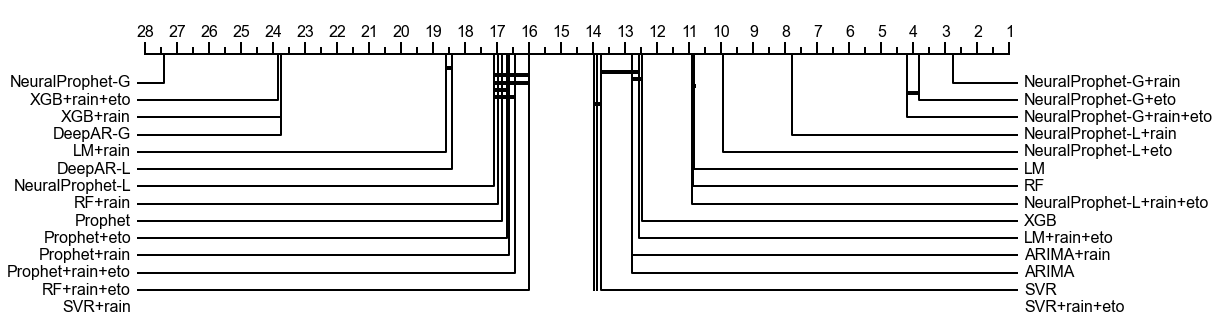

In [90]:
common_df.accuracy = -common_df.accuracy
draw_cd_diagram(common_df, fig_width=15, fname='Images/cd-all.jpg')

- Le modèle linéaire (LM) est celui qui donnes les meilleures prévisions lorsqu'il y a pas de données exogènes.
- NeuralProphet est la combinaison qui donne les meilleures prévisions en présence de données exogènes, en particulier en présence de données pluviométriques.
- NeuralProphet est meilleur en mode Global
- L'utilisation des données exogènes améliore significativement les prévisions de NeuralProphet. Les meilleures prévisions sont obtenues en utilisant uniquement la pluie. 
- Les données exogènes n'ont pas d'influence sur le modèle Prophet et ARIMA
- DeepAR-Local donne des prévisions significativement plus justes que DeepAR-Global. D'ailleurs DeepAR-Global est le modèle le moins bon.
- La dégradation observée sur les prévisions de XGB et RF lorsque les données exogènes sont utilisées est non négligeable.
- La combinaison Conv+rain+eto donne des prévisions similaires à DeepAR-Local. Ce qui est remarquable étant donné la simplicité du modèle Conv et son temps d'apprentissage réduit.

# Plot some forecasts

In [21]:
neuralProphetRain = all_result[(all_result.model=='NeuralProphet-G+rain') & (all_result.use_exo_rain) & (~all_result.use_exo_eto) & (~all_result.use_exo_bdlisa)]
h_cols = neuralProphetRain.columns[neuralProphetRain.columns.str.startswith('h')]
neuralProphetRain = neuralProphetRain.set_index('id_piezo')[h_cols]
neuralProphetRain.head()

,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h84,h85,h86,h87,h88,h89,h90,h91,h92,h93
id_piezo,,,,,,,,,,,,,,,,,,,,,
00065X0148/P,0.775936,0.845409,0.935739,1.003435,1.048758,1.069359,1.103693,0.883974,0.887938,0.918365,...,0.840830,0.899403,0.922857,0.928490,0.959660,1.030748,1.056622,0.837044,0.701065,0.285860
00068X0010/F295,24.816805,24.876612,24.874853,24.883207,24.916159,24.938890,24.909079,24.876314,24.939700,24.968775,...,23.808023,23.794329,23.738550,23.724398,23.694056,23.680613,23.636309,23.305834,23.478193,23.033201
00127X0873/PZ1,1.078173,1.110266,1.122379,1.092396,1.098412,1.090616,1.056395,1.018908,1.127817,1.149361,...,0.955477,0.958261,1.052299,1.017111,1.004213,1.004990,0.989723,0.971622,1.019255,0.882137
00134X0127/PZ1,22.434015,22.454760,22.465440,22.463133,22.463740,22.466470,22.424986,22.356543,22.422804,22.432177,...,22.200342,22.200232,22.190820,22.186522,22.189775,22.200056,22.178595,22.100400,22.131521,21.992704
00148D0177/F2,6.700272,6.713194,6.711308,6.716801,6.725126,6.746904,6.733427,6.686462,6.750181,6.760105,...,6.026003,6.037352,6.042555,6.045155,6.053492,6.071001,6.075321,5.885187,5.822000,5.365976


In [2]:
history = pd.read_csv('../data_collection/dataset_nomissing_linear.csv', sep=',', index_col='bss', parse_dates=['time'])
history = history[history.time < "2021-01-16"]

In [3]:
history.loc['00065X0148/P']

,Unnamed: 0,time,tp,e,p
bss,,,,,
00065X0148/P,2398,2015-01-01,0.000015,-0.005951,0.89
00065X0148/P,2399,2015-01-02,0.000791,-0.012997,0.95
00065X0148/P,2400,2015-01-03,0.012880,-0.009395,0.72
00065X0148/P,2401,2015-01-04,0.000005,-0.007145,0.70
00065X0148/P,2402,2015-01-05,0.000072,-0.002743,0.78
...,...,...,...,...,...
00065X0148/P,4600,2021-01-11,0.001994,-0.005845,1.08
00065X0148/P,4601,2021-01-12,0.007698,-0.020109,0.81
00065X0148/P,4602,2021-01-13,0.005463,-0.003029,0.67


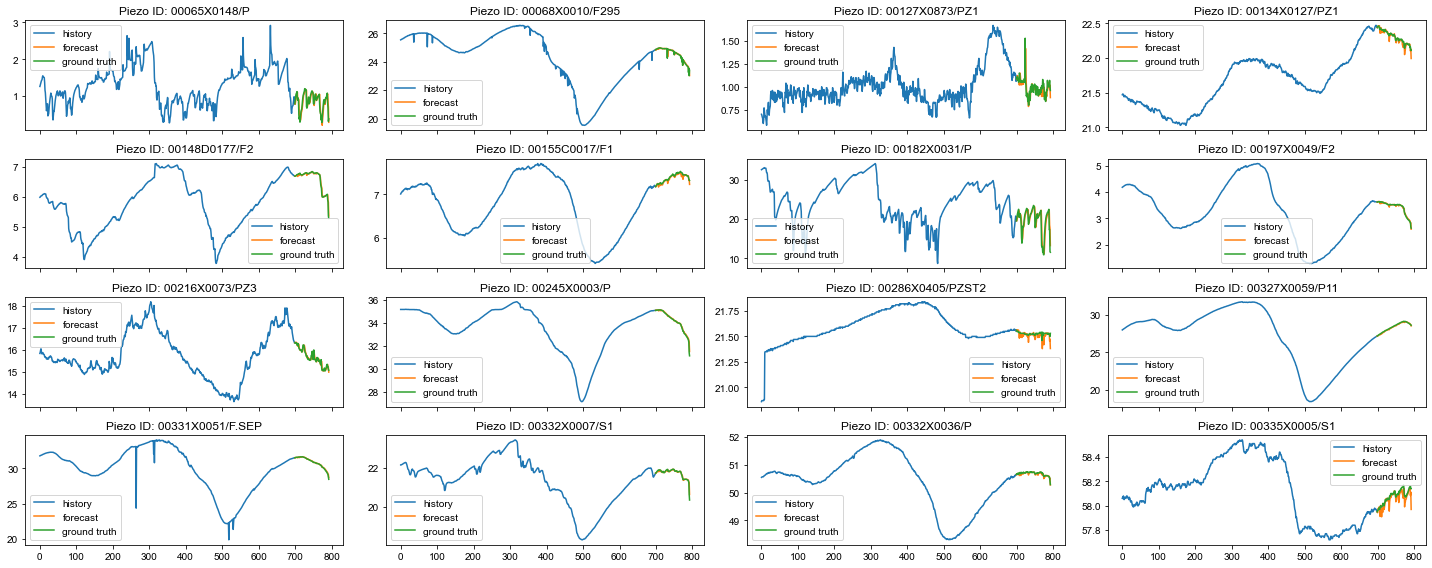

In [93]:
h_length = 700
horizon = 93
id_piezo = '00065X0148/P'

nrows = 4
ncols = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=False, figsize=(20, 8), tight_layout=True)

for i, id_piezo in enumerate(neuralProphetRain.index[:(ncols*nrows)]):
    h_values = history.loc[id_piezo].p.values[-h_length-horizon:-horizon] # history
    f_values = np.insert(neuralProphetRain.loc[id_piezo].values, 0, h_values[-1]) # forecasts
    t_values = history.loc[id_piezo].p.values[-horizon-1:] # ground truths for forecasts
    
    h_index = np.arange(h_length)
    f_index = np.arange(h_length - 1, h_length + horizon)
    
    r = i // ncols
    c = i - r * ncols
    
    axes[r,c].plot(h_index, h_values, label='history')
    axes[r,c].plot(f_index, f_values, label='forecast')
    axes[r,c].plot(f_index, t_values, label='ground truth')
    axes[r,c].set_title(f'Piezo ID: {id_piezo}')
    axes[r,c].legend()
    
plt.tight_layout()
plt.savefig('Images/some-forecasts.jpg')